### NEEEEWWWW

In [ ]:
from __future__ import annotations
import random, pathlib, json
from dataclasses import dataclass, asdict
from collections import Counter
from typing import Tuple, Dict, Optional, List

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


# ────────────────────────────────────────────────────────────────────────────────
# Config
# ────────────────────────────────────────────────────────────────────────────────

@dataclass
class Config:
    runs: int = 1000
    L: int = 32

    # Dynamics (base rates)
    beta_T: float = 0.30
    beta_F: float = 0.30

    # Blue layer
    p_rewire: float = 0.05
    k_blue: float = 4.0            # can be non-integer in 'grid_k'
    blue_mode: str = 'ws_nx'       # 'ws_nx' | 'grid_ws' | 'grid_k'

    # Red (BA) layer
    m0_red: int = 4
    m_red: int = 2                 # set 0 to disable BA layer entirely

    # Color-dependent multipliers for (beta_T_on_layer, beta_F_on_layer)
    # keys: 'blue' , 'red'
    color_beta_multipliers: Dict[str, Tuple[float, float]] = None

    max_steps: int = 2_000_000     # safety cap; DFS terminates well before this
    force_finish: bool = False     # unused by DFS, kept for compatibility

    # Batch & IO
    seed: Optional[int] = 12345
    outdir: str = 'batch_outputs'
    show: bool = True
    fixednet: bool = True

    # Diagnostics
    print_diagnostics: bool = True


# ────────────────────────────────────────────────────────────────────────────────
# Network construction
# ────────────────────────────────────────────────────────────────────────────────

def grid_positions(L: int) -> Dict[int, Tuple[int, int]]:
    N = L * L
    return {i: (i % L, i // L) for i in range(N)}

def build_blue_ws_nx(N: int, k: int, p: float, rng: random.Random) -> nx.Graph:
    seed = rng.randrange(2**32 - 1)
    return nx.watts_strogatz_graph(n=N, k=k, p=p, seed=seed)

def build_blue_grid_ws(L: int, p: float, rng: random.Random) -> nx.Graph:
    grid = nx.grid_2d_graph(L, L, periodic=True)
    mapping = {n: i for i, n in enumerate(grid.nodes())}
    G = nx.relabel_nodes(grid, mapping).copy()
    N = L * L

    for u, v in list(G.edges()):
        if rng.random() < p:
            G.remove_edge(u, v)
            while True:
                w = rng.randrange(N)
                if w != u and not G.has_edge(u, w):
                    G.add_edge(u, w)
                    break
    return G

def build_blue_grid_k(L: int, target_k: float, rng: random.Random) -> nx.Graph:
    """
    2D periodic grid builder with mean degree ≈ target_k.
    Ensures real horizontal/vertical edges exist; adds shells of neighbors
    (by increasing distance) to reach the target number of edges.
    """
    N = L * L

    def nid(x, y):
        return (y % L) * L + (x % L)

    # Displacements grouped by squared distance (shells)
    disp = []
    max_r = max(4, L // 2)
    for dx in range(-max_r, max_r + 1):
        for dy in range(-max_r, max_r + 1):
            if dx == 0 and dy == 0: continue
            disp.append((dx*dx + dy*dy, dx, dy))
    disp.sort(key=lambda t: t[0])

    shells: List[List[Tuple[int, int]]] = []
    cur_d2 = None; cur_shell: List[Tuple[int,int]] = []
    for d2, dx, dy in disp:
        if cur_d2 is None or d2 != cur_d2:
            if cur_shell: shells.append(cur_shell)
            cur_d2 = d2; cur_shell = []
        cur_shell.append((dx, dy))
    if cur_shell: shells.append(cur_shell)

    M_target = int(round(N * float(target_k) / 2.0))
    G = nx.Graph(); G.add_nodes_from(range(N))

    def edges_for_disps(disps):
        E = []
        for y in range(L):
            for x in range(L):
                u = nid(x, y)
                for dx, dy in disps:
                    v = nid(x + dx, y + dy)
                    if u < v:
                        E.append((u, v))
        return list(set(E))

    m_now = 0
    for si, sh in enumerate(shells):
        Es = edges_for_disps(sh); rng.shuffle(Es)
        need = M_target - m_now
        if need <= 0: break

        if si == 0 and target_k < 4.0:
            Es = Es[:max(0, need)]
            for (u, v) in Es:
                if not G.has_edge(u, v):
                    G.add_edge(u, v); m_now += 1
            break
        else:
            for (u, v) in Es:
                if m_now >= M_target: break
                if not G.has_edge(u, v):
                    G.add_edge(u, v); m_now += 1

    if G.number_of_edges() == 0:
        first_shell = shells[0]
        Es = edges_for_disps(first_shell); rng.shuffle(Es)
        take = min(max(1, M_target), len(Es))
        for u, v in Es[:take]:
            if not G.has_edge(u, v):
                G.add_edge(u, v)

    return G

def build_red_ba(N: int, m0: int, m: int, rng: random.Random):
    red = nx.Graph()
    red.add_nodes_from(range(N))
    if m <= 0 or m0 <= 0:
        return red

    init = rng.sample(range(N), m0)
    for i in range(m0):
        for j in range(i + 1, m0):
            red.add_edge(init[i], init[j])

    targets = list(init)
    for new in range(N):
        if new in init: continue
        chosen = set()
        while len(chosen) < m:
            t = rng.choice(targets)
            if t != new: chosen.add(t)
        for t in chosen:
            red.add_edge(new, t)
        targets.extend([new] * m)
    return red

def rewire_edges_ws_like(G: nx.Graph, p: float, rng: random.Random) -> nx.Graph:
    """
    For each edge (u,v), with prob p rewire the v-end to a random node w,
    keeping u fixed (WS-style). Preserves simple graph (no self loops/dups).
    """
    if p <= 0.0 or G.number_of_edges() == 0:
        return G

    N = G.number_of_nodes()
    edges = list(G.edges())  # snapshot
    for (u, v) in edges:
        # Impose an orientation so we don't try to rewire the same undirected edge twice
        if u > v:
            u, v = v, u
        if not G.has_edge(u, v):  # may have been rewired already
            continue
        if rng.random() < p:
            # draw a new endpoint w for edge (u,w)
            while True:
                w = rng.randrange(N)
                if w != u and not G.has_edge(u, w):
                    break
            G.remove_edge(u, v)
            G.add_edge(u, w)
    return G


def build_layers(cfg: Config, rng: random.Random):
    L = cfg.L
    N = L * L
    pos = grid_positions(L)

    # Blue layer
    if cfg.blue_mode == 'ws_nx':
        blue_raw = build_blue_ws_nx(N, int(round(cfg.k_blue)), cfg.p_rewire, rng)
        # 'ws_nx' already includes WS rewiring internally; no extra rewiring here.
    elif cfg.blue_mode == 'grid_ws':
        if int(round(cfg.k_blue)) != 4:
            raise ValueError("blue_mode='grid_ws' requires k_blue == 4.")
        blue_raw = build_blue_grid_ws(L, 0.0, rng)  # build the 4-neighbor grid (no rewiring here)
        blue_raw = rewire_edges_ws_like(blue_raw, cfg.p_rewire, rng)
    elif cfg.blue_mode == 'grid_k':
        blue_raw = build_blue_grid_k(L, cfg.k_blue, rng)  # build to target mean degree
        blue_raw = rewire_edges_ws_like(blue_raw, cfg.p_rewire, rng)  # <-- ADD THIS
    else:
        raise ValueError("blue_mode must be 'ws_nx', 'grid_ws', or 'grid_k'.")


    # Red layer (BA)
    red_raw = build_red_ba(N, cfg.m0_red, cfg.m_red, rng)


    # Merge with flags (no 'mixed' label)
    G = nx.Graph(); G.add_nodes_from(range(N))
    for u, v in blue_raw.edges():
        if u == v: continue
        if not G.has_edge(u, v):
            G.add_edge(u, v, blue=True, red=False)
        else:
            G[u][v]['blue'] = True
    for u, v in red_raw.edges():
        if u == v: continue
        if not G.has_edge(u, v):
            G.add_edge(u, v, blue=False, red=True)
        else:
            G[u][v]['red'] = True

    return G, pos


# ────────────────────────────────────────────────────────────────────────────────
# Diagnostics
# ────────────────────────────────────────────────────────────────────────────────

def largest_cc_subgraph(G: nx.Graph):
    if G.number_of_nodes() == 0:
        return G
    if nx.is_connected(G):
        return G
    comp = max(nx.connected_components(G), key=len)
    return G.subgraph(comp).copy()

def network_diagnostics(G: nx.Graph, label: str):
    def stats(H: nx.Graph):
        Hcc = largest_cc_subgraph(H)
        n = Hcc.number_of_nodes()
        m = Hcc.number_of_edges()
        degs = [d for _, d in Hcc.degree()]
        kavg = float(np.mean(degs)) if degs else 0.0
        clus = float(nx.average_clustering(Hcc)) if n > 1 else 0.0
        try:
            aspl = float(nx.average_shortest_path_length(Hcc)) if n > 1 else float('nan')
        except Exception:
            aspl = float('nan')
        return dict(nodes=n, edges=m, k_avg=kavg, clustering=clus, aspl=aspl)

    out = {f"{label}_overall": stats(G)}
    for layer_name, key in [('blue', 'blue'), ('red', 'red')]:
        E = [(u, v) for u, v, a in G.edges(data=True) if a.get(key, False)]
        H = nx.Graph(); H.add_nodes_from(G.nodes()); H.add_edges_from(E)
        out[f"{label}_{layer_name}"] = stats(H)
    return out

def print_diagnostics(diag: Dict[str, Dict[str, float]]):
    def fmt(d):
        return (f"n={d['nodes']}, m={d['edges']}, ⟨k⟩={d['k_avg']:.2f}, "
                f"C={d['clustering']:.3f}, L={d['aspl']:.3f}")
    print("─ Network diagnostics ─")
    for k, v in diag.items():
        print(f"{k:>18}: {fmt(v)}")


# ────────────────────────────────────────────────────────────────────────────────
# DFS-based simultaneous spreading
# ────────────────────────────────────────────────────────────────────────────────

def simulate_once(seed: int, *,
                  cfg: Config,
                  G_template: Optional[nx.Graph] = None,
                  pos: Optional[Dict[int, Tuple[int, int]]] = None,
                  collect_trace: bool = False):
    rng = random.Random(seed)

    # Build or reuse network
    if G_template is None:
        G, pos = build_layers(cfg, rng)
    else:
        G = G_template

    N = len(G)

    # States: 'S' = susceptible, 'T' = true, 'F' = false
    state = {n: 'S' for n in G}
    t_seed, f_seed = rng.sample(range(N), 2)
    state[t_seed] = 'T'
    state[f_seed] = 'F'

    # Multipliers (defaults = (1,1))
    mults = cfg.color_beta_multipliers or {
        'blue': (1.0, 1.0),
        'red':  (1.0, 1.0)
    }
    # T spreads only on blue edges
    bT = cfg.beta_T * mults.get('blue', (1.0, 1.0))[0]
    # F spreads only on red edges
    bF = cfg.beta_F * mults.get('red',  (1.0, 1.0))[1]

    # Precompute neighbors per layer
    nbrs_blue = {n: [] for n in G}
    nbrs_red  = {n: [] for n in G}
    for u, v, a in G.edges(data=True):
        if a.get('blue', False):
            nbrs_blue[u].append(v)
            nbrs_blue[v].append(u)
        if a.get('red', False):
            nbrs_red[u].append(v)
            nbrs_red[v].append(u)

    # Layer subgraphs (for per-layer clustering/degree)
    H_blue = nx.Graph(); H_blue.add_nodes_from(G.nodes())
    H_blue.add_edges_from((u, v) for u, v, a in G.edges(data=True) if a.get('blue', False))
    H_red  = nx.Graph(); H_red.add_nodes_from(G.nodes())
    H_red.add_edges_from((u, v) for u, v, a in G.edges(data=True) if a.get('red', False))

    # Seed-local features on the CORRECT layer
    cl_T_seed_blue = nx.clustering(H_blue, t_seed)
    cl_F_seed_red  = nx.clustering(H_red,  f_seed)
    deg_T_blue     = H_blue.degree[t_seed]
    deg_F_red      = H_red.degree[f_seed]

    # Global sets
    Tset = {t_seed}
    Fset = {f_seed}
    S_count = N - len(Tset) - len(Fset)

    # Trace over time (optional)
    trace_T, trace_F = [], []
    if collect_trace:
        trace_T.append(len(Tset))
        trace_F.append(len(Fset))

    steps = 0
    attempts_total = 0

    # Helper to compute frontier given current state
    def compute_frontiers():
        frontier_T = {u for u in Tset if any(state[v] == 'S' for v in nbrs_blue[u])}
        frontier_F = {u for u in Fset if any(state[v] == 'S' for v in nbrs_red[u])}
        return frontier_T, frontier_F

    # Main loop: wave-like, frontier-based spreading
    while S_count > 0:
        steps += 1

        frontier_T, frontier_F = compute_frontiers()

        # TRUE stopping condition: no T or F node has any S neighbor.
        if not frontier_T and not frontier_F:
            break

        proposed_T = set()
        proposed_F = set()

        # --- T process: از فرانتیر T روی یال‌های آبی ---
        if bT > 0.0 and frontier_T:
            for u in frontier_T:
                for v in nbrs_blue[u]:
                    if state[v] != 'S':
                        continue
                    attempts_total += 1
                    if rng.random() < bT:
                        proposed_T.add(v)

        # --- F process: از فرانتیر F روی یال‌های قرمز ---
        if bF > 0.0 and frontier_F:
            for u in frontier_F:
                for v in nbrs_red[u]:
                    if state[v] != 'S':
                        continue
                    attempts_total += 1
                    if rng.random() < bF:
                        proposed_F.add(v)

        

        new_T = set()
        new_F = set()

        only_T = proposed_T - proposed_F
        only_F = proposed_F - proposed_T
        both   = proposed_T & proposed_F

        # فقط T موفق شده
        for v in only_T:
            if state[v] == 'S':
                state[v] = 'T'
                new_T.add(v)

        # فقط F موفق شده
        for v in only_F:
            if state[v] == 'S':
                state[v] = 'F'
                new_F.add(v)

       
        for v in both:
            if state[v] != 'S':
                continue
            if rng.random() < 0.5:
                state[v] = 'T'
                new_T.add(v)
            else:
                state[v] = 'F'
                new_F.add(v)

        newly_infected = len(new_T) + len(new_F)

        
        # به‌روزرسانی مجموعه‌ها
        if newly_infected > 0:
            Tset |= new_T
            Fset |= new_F
            S_count -= newly_infected

            if collect_trace:
                trace_T.append(len(Tset))
                trace_F.append(len(Fset))

        if S_count <= 0:
            break

    # Final counts
    Tcnt = len(Tset)
    Fcnt = len(Fset)
    S_final = S_count

    # Diagnostics for seeds (combined graph metrics)
    deg_T_comb = G.degree(t_seed)
    deg_F_comb = G.degree(f_seed)
    try:
        dist_TF = nx.shortest_path_length(G, t_seed, f_seed)
    except nx.NetworkXNoPath:
        dist_TF = np.inf

    winner = 'T' if Tcnt > Fcnt else ('F' if Fcnt > Tcnt else 'tie')

    return dict(
        T=Tcnt, F=Fcnt,
        # per-layer seed features (use these for win-prob plots)
        deg_T_blue=deg_T_blue, deg_F_red=deg_F_red,
        cl_T_seed_blue=cl_T_seed_blue, cl_F_seed_red=cl_F_seed_red,
        # optional combined-graph degrees if you still want them
        deg_T=deg_T_comb, deg_F=deg_F_comb,
        dist=dist_TF,
        finished=(S_final == 0),
        steps=steps,
        attempts=attempts_total,
        trace_T=trace_T if collect_trace else None,
        trace_F=trace_F if collect_trace else None,
        winner=winner,
    )

# ────────────────────────────────────────────────────────────────────────────────
# Batch, plotting, and summary
# ────────────────────────────────────────────────────────────────────────────────

def make_cfg(**kwargs):
    cfg = Config()
    for k, v in kwargs.items():
        setattr(cfg, k, v)
    return cfg

def _initial_layer_stats(G: nx.Graph):
    """Return avg clustering (and a couple of basics) for blue/red layers on the LCC."""
    def to_layer(Hkey: str):
        E = [(u, v) for u, v, a in G.edges(data=True) if a.get(Hkey, False)]
        H = nx.Graph(); H.add_nodes_from(G.nodes()); H.add_edges_from(E)
        Hcc = largest_cc_subgraph(H)
        n = Hcc.number_of_nodes()
        if n <= 1:
            return dict(n=n, k_avg=0.0, C=0.0, trans=0.0)
        degs = [d for _, d in Hcc.degree()]
        kavg = float(np.mean(degs)) if degs else 0.0
        C = float(nx.average_clustering(Hcc))
        T = float(nx.transitivity(Hcc))
        return dict(n=n, k_avg=kavg, C=C, trans=T)
    return dict(blue=to_layer('blue'), red=to_layer('red'))


def run_batch(cfg: Config):
    outroot = pathlib.Path(cfg.outdir); outroot.mkdir(exist_ok=True)

    fixedG, fixedPos = (None, None)
    if cfg.fixednet:
        base_seed = cfg.seed if cfg.seed is not None else random.randrange(2**32)
        fixedG, fixedPos = build_layers(cfg, random.Random(base_seed))
        if cfg.print_diagnostics:
            diag = network_diagnostics(fixedG, label="combined")
            print_diagnostics(diag)
    else:
        if cfg.print_diagnostics:
            gtmp, _ = build_layers(cfg, random.Random(cfg.seed or 0))
            diag = network_diagnostics(gtmp, label="combined")
            print_diagnostics(diag)

        # --- Initial (pre-spread) per-layer clustering to include in summary ---
    if cfg.fixednet and fixedG is not None:
        init_layer = _initial_layer_stats(fixedG)
    else:
        # representative network for the summary (same seed path you already use)
        gtmp, _ = build_layers(cfg, random.Random(cfg.seed or 0))
        init_layer = _initial_layer_stats(gtmp)

    Cb0 = init_layer['blue']['C']
    Cr0 = init_layer['red' ]['C']

    results = []
    exemplar_trace = None  # (trace_T, trace_F)
    for i in range(cfg.runs):
        seed = (cfg.seed or random.randrange(2**32)) + i
        res = simulate_once(seed,
                            cfg=cfg,
                            G_template=fixedG,
                            pos=fixedPos,
                            collect_trace=(i == 0))  # keep one trace for plotting
        if i == 0:
            if res.get('trace_T') is not None:
                exemplar_trace = (res['trace_T'], res['trace_F'])
        results.append(res)
        winners = np.array([r['winner'] for r in results])  # 'T' | 'F' | 'tie'
        p_T = float(np.mean(winners == 'T'))
        p_F = float(np.mean(winners == 'F'))
        p_tie = float(np.mean(winners == 'tie'))

        if (i + 1) % max(1, cfg.runs // 10) == 0:
            print(f" · {i + 1}/{cfg.runs} runs done", flush=True)

    # arrays
    N = cfg.L * cfg.L
    T_all = np.array([r['T'] for r in results])
    F_all = np.array([r['F'] for r in results])
    done = np.array([r['finished'] for r in results], dtype=bool)

    n_finished = int(done.sum())
    n_unfinished = int((~done).sum())
    if n_unfinished:
        print(f" {n_unfinished}/{cfg.runs} runs ended with some susceptibles (disconnected or failed attempts).")

    
    idx = np.ones_like(done, dtype=bool)

    T = T_all[idx]; F = F_all[idx]; D = T - F
    # Winner per run by "more nodes" rule
    winners = np.where(T > F, 'T', np.where(F > T, 'F', 'tie'))
    p_T   = float((winners == 'T').mean())
    p_F   = float((winners == 'F').mean())
    p_tie = float((winners == 'tie').mean())


    deg_diff = np.array([r['deg_T_blue']     - r['deg_F_red']      for r in results])[idx]
    cl_diff  = np.array([r['cl_T_seed_blue'] - r['cl_F_seed_red']  for r in results])[idx]
    dist_tf  = np.array([r['dist']                 for r in results])[idx]

    steps_all    = np.array([r['steps']    for r in results])[idx]
    attempts_all = np.array([r['attempts'] for r in results])[idx]

    # safe correlations
    def safe_corr(x, y):
        x = np.asarray(x); y = np.asarray(y)
        if x.size < 2 or y.size < 2:
            return float('nan'), float('nan')
        try:
            r = float(pearsonr(x, y)[0])
        except Exception:
            r = float('nan')
        try:
            rs = float(spearmanr(x, y)[0])
        except Exception:
            rs = float('nan')
        return r, rs

    # figure 1: histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    def hist_prob_with_mean(ax, data, color, title, xlabel, nbins='auto'):
        if data.size == 0:
            ax.text(0.5, 0.5, 'no data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
            return np.array([]), np.array([])
        weights = np.ones_like(data, dtype=float) / data.size
        edges = np.histogram_bin_edges(data, bins=nbins)
        vals, bins, _ = ax.hist(
            data, bins=edges, weights=weights, alpha=0.8,
            color=color, edgecolor='none'
        )
        m = float(np.mean(data))
        ax.axvline(m, color='k', ls='--', lw=1)
        ax.annotate(f'{m:.1f}', xy=(m, vals.max()*1.05), xytext=(0, 0),
                    textcoords='offset points', ha='center', va='bottom',
                    fontsize=9, fontweight='bold')
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel('probability')
        return vals, bins

    hist_prob_with_mean(axs[0, 0], T, '#2ca02c', 'Final T-nodes (green)', '# nodes')
    hist_prob_with_mean(axs[0, 1], F, '#e41a1c', 'Final F-nodes (red)',   '# nodes')

    if D.size:
        weights_D = np.ones_like(D, dtype=float) / D.size
        edges_D = np.histogram_bin_edges(D, bins='auto')
        vals_D, bins_D, _ = axs[1, 0].hist(
            D, bins=edges_D, weights=weights_D,
            color='#bdbdbd', alpha=0.9, edgecolor='none'
        )
        axs[1, 0].axvline(0, color='k', lw=1)
        axs[1, 0].set_title('Dominance Δ = T − F')
        axs[1, 0].set_xlabel('Δ  (positive → T wins)')
        axs[1, 0].set_ylabel('probability')

        xL, xR = float(D.min()), float(D.max())
        yTop = float(vals_D.max()) * 1.05 if vals_D.size else 0.1
        axs[1, 0].annotate(f'F wins {p_F*100:.1f}%',   xy=(xL, yTop), xytext=(0, 0),
                        textcoords='offset points', ha='left',  va='bottom')
        axs[1, 0].annotate(f'T wins {p_T*100:.1f}%',   xy=(xR, yTop), xytext=(0, 0),
                        textcoords='offset points', ha='right', va='bottom')
        axs[1, 0].annotate(f'tie {p_tie*100:.1f}%',    xy=(0,  yTop), xytext=(0, 14),
                        textcoords='offset points', ha='center', va='bottom')
    else:
        axs[1, 0].text(0.5, 0.5, 'no data', ha='center', va='center',
                       transform=axs[1, 0].transAxes)

    run_idx = np.arange(T.size)
    axs[1, 1].scatter(run_idx, T, s=9, alpha=0.75, color='#2ca02c', label='T')
    axs[1, 1].scatter(run_idx, F, s=9, alpha=0.75, color='#e41a1c', label='F')
    axs[1, 1].axhline((cfg.L * cfg.L) / 2, color='k', lw=0.8, ls=':')
    axs[1, 1].set_title('Final counts per run')
    axs[1, 1].set_xlabel('run index'); axs[1, 1].set_ylabel('# nodes')
    axs[1, 1].legend(loc='best', frameon=False)

    plt.tight_layout()
    fig.savefig(outroot / f"summary_plots_{cfg.runs}runs.png", dpi=300)
    if cfg.show: plt.show()
    plt.close(fig)

    # helpers for binned lines
    def _bin_means(x, y, nbins=8):
        x = np.asarray(x); y = np.asarray(y)
        if x.size == 0 or y.size == 0 or np.all(np.isnan(x)) or np.all(np.isnan(y)):
            return np.array([]), np.array([])
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins + 1)
        if not np.all(np.isfinite(edges)): return np.array([]), np.array([])
        mids = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges[1:-1])
        means = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                means[k] = np.nanmean(y[sel])
        return mids, means

    def _bin_winprob(x, winners, nbins=8):
        x = np.asarray(x); winners = np.asarray(winners)
        edges = np.linspace(np.nanmin(x), np.nanmax(x), nbins + 1)
        mids = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges[1:-1])
        p = np.full(nbins, np.nan)
        for k in range(nbins):
            sel = (idx == k)
            if np.any(sel):
                p[k] = np.mean(winners[sel] == 'T')
        return mids, p


    # figure 2: seed effects
    fig2, ax2 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff, 'Δ degree'),
                                      (cl_diff, 'Δ clustering'),
                                      (dist_tf, 'd(T,F)')]):
        ax2[i].scatter(arr, D, s=12, alpha=0.6)
        xm, ym = _bin_means(arr, D, nbins=8)
        if xm.size:
            ax2[i].plot(xm, ym, marker='o', lw=1)
        r, _ = safe_corr(arr, D)
        rs, _ = safe_corr(arr, np.argsort(np.argsort(D)))
        ax2[i].set_xlabel(label)
        if i == 0:
            ax2[i].set_ylabel('Δ = T – F')
        ax2[i].set_title(f'{label} vs Δ\nPearson r={r:.2f}, Spearman ~={rs:.2f}')

    plt.tight_layout()
    fig2.savefig(outroot / f"seed_effects_{cfg.runs}runs.png", dpi=300)
    if cfg.show: plt.show()
    plt.close(fig2)

    # figure 3: win probability
    fig3, ax3 = plt.subplots(1, 3, figsize=(15, 4))
    for i, (arr, label) in enumerate([(deg_diff, 'Δ degree'),
                                      (cl_diff, 'Δ clustering'),
                                      (dist_tf, 'd(T,F)')]):
        xm, p = _bin_winprob(arr, winners, nbins=8)

        if xm.size:
            ax3[i].plot(xm, p, marker='o')
        ax3[i].axhline(0.5, color='k', ls=':', lw=1)
        ax3[i].set_ylim(0, 1)
        ax3[i].set_xlabel(label)
        if i == 0:
            ax3[i].set_ylabel('P(T wins)')
        ax3[i].set_title(f'Win probability vs {label}')
    plt.tight_layout()
    fig3.savefig(outroot / f"winprob_{cfg.runs}runs.png", dpi=300)
    if cfg.show: plt.show()
    plt.close(fig3)

    # figure 4: map
    if cfg.fixednet and fixedG is not None:
        Gmap, posmap = fixedG, fixedPos
    else:
        Gmap, posmap = build_layers(cfg, random.Random(cfg.seed or 0))
    if not posmap:
        posmap = nx.spring_layout(Gmap, seed=cfg.seed or 0)

    e_blue_only = [(u, v) for u, v, a in Gmap.edges(data=True) if a.get('blue', False) and not a.get('red', False)]
    e_red_only  = [(u, v) for u, v, a in Gmap.edges(data=True) if a.get('red',  False) and not a.get('blue', False)]
    e_both      = [(u, v) for u, v, a in Gmap.edges(data=True) if a.get('blue', False) and a.get('red', False)]

    fig4 = plt.figure(figsize=(10, 10))
    ax4  = plt.gca(); ax4.set_aspect('equal'); ax4.axis('off')
    nx.draw_networkx_nodes(Gmap, posmap, node_size=8, node_color="#000000", linewidths=0.0, ax=ax4)
    if e_blue_only:
        nx.draw_networkx_edges(Gmap, posmap, edgelist=e_blue_only, width=0.6, edge_color='#1f78b4', alpha=0.65, ax=ax4)
    if e_both:
        nx.draw_networkx_edges(Gmap, posmap, edgelist=e_both, width=0.6, edge_color='#1f78b4', alpha=0.35, ax=ax4)
    if e_red_only:
        nx.draw_networkx_edges(Gmap, posmap, edgelist=e_red_only,  width=0.6, edge_color='#e31a1c', alpha=0.8, ax=ax4)
    if e_both:
        nx.draw_networkx_edges(Gmap, posmap, edgelist=e_both, width=0.6, edge_color='#e31a1c', alpha=0.9, ax=ax4)
    from matplotlib.lines import Line2D
    handles = [Line2D([0], [0], color='#1f78b4', lw=2, label='blue'),
               Line2D([0], [0], color='#e31a1c', lw=2, label='red')]
    ax4.legend(handles=handles, loc='lower left', frameon=False)
    fig4.tight_layout()
    fig4.savefig(outroot / f"graph_map_{cfg.runs}runs.png", dpi=300)
    if cfg.show: plt.show()
    plt.close(fig4)

    # figure 5: spread time (new)
    fig5, ax5 = plt.subplots(1, 2, figsize=(14, 4))
    # steps histogram
    # steps histogram — FIXED
    weights = np.ones_like(steps_all, dtype=float) / steps_all.size
    edges = np.histogram_bin_edges(steps_all, bins='auto')  # compute edges without weights
    ax5[0].hist(steps_all, bins=edges, weights=weights, color='#969696', edgecolor='none')
    ax5[0].set_title('Steps to completion (global steps)')
    ax5[0].set_xlabel('steps'); ax5[0].set_ylabel('probability')
    mu, md = float(np.mean(steps_all)), float(np.median(steps_all))
    ax5[0].axvline(mu, color='k', ls='--', lw=1); ax5[0].annotate(f'mean={mu:.1f}', xy=(mu, ax5[0].get_ylim()[1]*0.9))
    ax5[0].axvline(md, color='k', ls=':', lw=1); ax5[0].annotate(f'median={md:.1f}', xy=(md, ax5[0].get_ylim()[1]*0.8))

    # exemplar trace
    if exemplar_trace is not None:
        tT, tF = exemplar_trace
        steps_axis = np.arange(1, len(tT)+1)
        ax5[1].plot(steps_axis, tT, label='T(t)', marker='o', ms=3, lw=1)
        ax5[1].plot(steps_axis, tF, label='F(t)', marker='o', ms=3, lw=1)
        ax5[1].set_xlabel('step'); ax5[1].set_ylabel('# nodes'); ax5[1].set_title('One run: spread over time'); ax5[1].legend()
    else:
        ax5[1].text(0.5, 0.5, 'no trace collected', ha='center', va='center', transform=ax5[1].transAxes)
        ax5[1].set_axis_off()

    plt.tight_layout()
    fig5.savefig(outroot / f"spread_time_{cfg.runs}runs.png", dpi=300)
    if cfg.show: plt.show()
    plt.close(fig5)

    # JSON summary
    pear_deg, _ = safe_corr(deg_diff, D)
    pear_clust, _ = safe_corr(cl_diff, D)
    pear_dist, _ = safe_corr(dist_tf, D)

    with open(outroot / f"summary_{cfg.runs}runs.json", "w") as fh:
        json.dump({
            **asdict(cfg),
            "finished_runs": int(done.sum()),
            "unfinished_runs": int((~done).sum()),
            "mean_T": float(np.mean(T)) if T.size else None,
            "std_T": float(np.std(T, ddof=1)) if T.size > 1 else None,
            "mean_F": float(np.mean(F)) if F.size else None,
            "std_F": float(np.std(F, ddof=1)) if F.size > 1 else None,
            "mean_steps": float(np.mean(steps_all)) if steps_all.size else None,
            "median_steps": float(np.median(steps_all)) if steps_all.size else None,
            "mean_attempts": float(np.mean(attempts_all)) if attempts_all.size else None,
            "pearson_deg": pear_deg,
            "pearson_cl": pear_clust,
            "pearson_dist": pear_dist,
            "init_blue_nodes": init_layer["blue"]["n"],
            "init_blue_kavg" : init_layer["blue"]["k_avg"],
            "init_blue_C"    : init_layer["blue"]["C"],
            "init_blue_trans": init_layer["blue"]["trans"],
            "init_red_nodes" : init_layer["red"]["n"],
            "init_red_kavg"  : init_layer["red"]["k_avg"],
            "init_red_C"     : init_layer["red"]["C"],
            "init_red_trans" : init_layer["red"]["trans"],

        }, fh, indent=2)

    for num in plt.get_fignums():
        fig = plt.figure(num)
        fig.savefig(outroot / f"figure_{num}_{cfg.runs}runs.png", dpi=300)
    print("Finished – results in", outroot.resolve())

    S_final_all = [cfg.L * cfg.L - (r['T'] + r['F']) for r in results]
    print("Mean leftover S:", np.mean(S_final_all))
    print("Median leftover S:", np.median(S_final_all))
    print("Max leftover S:", np.max(S_final_all))







─ Network diagnostics ─
  combined_overall: n=1024, m=5601, ⟨k⟩=10.94, C=0.165, L=3.363
     combined_blue: n=1024, m=3584, ⟨k⟩=7.00, C=0.369, L=5.606
      combined_red: n=1024, m=2046, ⟨k⟩=4.00, C=0.009, L=4.944
 · 100/1000 runs done
 · 200/1000 runs done
 · 300/1000 runs done
 · 400/1000 runs done
 · 500/1000 runs done
 · 600/1000 runs done
 · 700/1000 runs done
 · 800/1000 runs done
 · 900/1000 runs done
 · 1000/1000 runs done
 768/1000 runs ended with some susceptibles (disconnected or failed attempts).


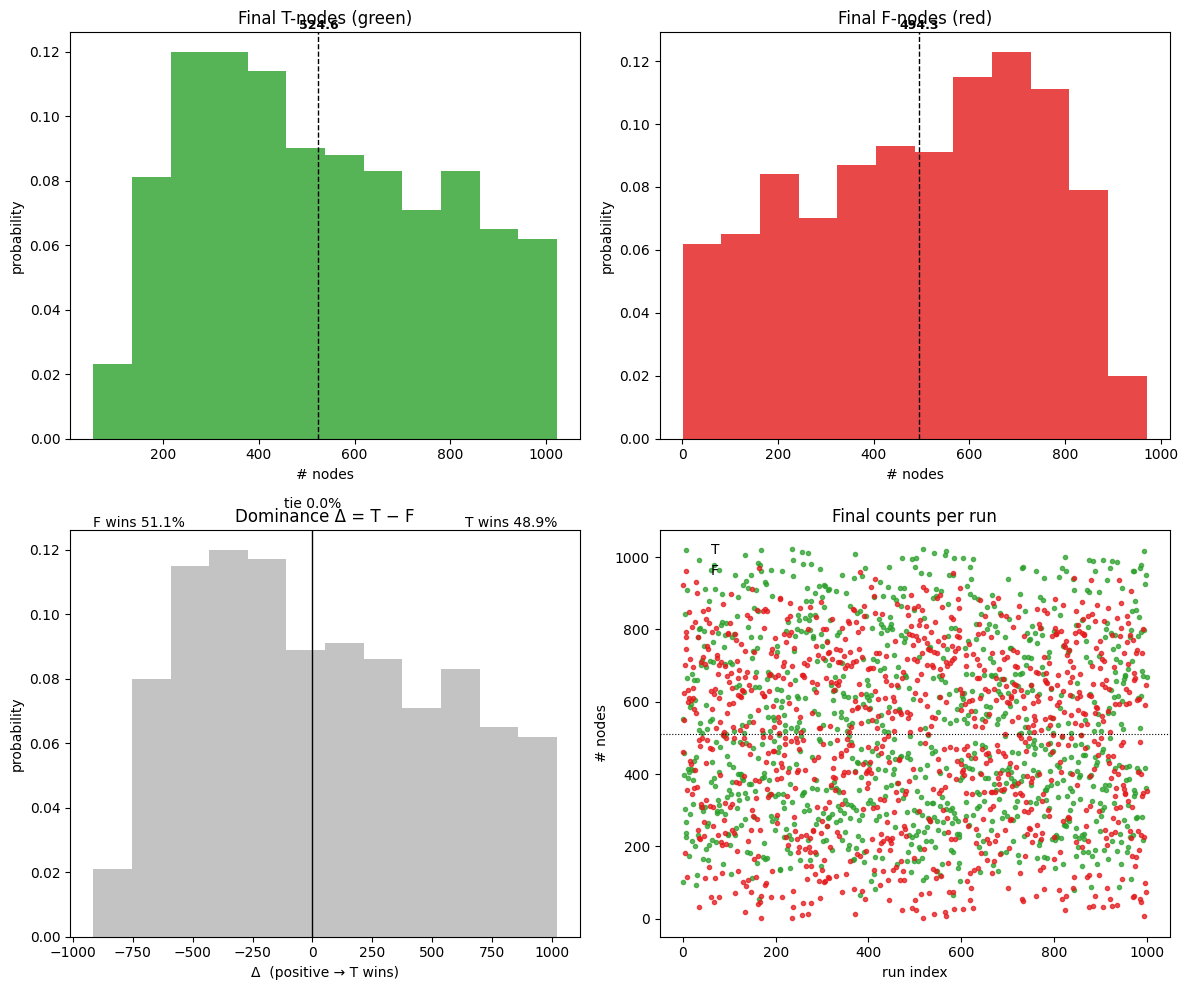

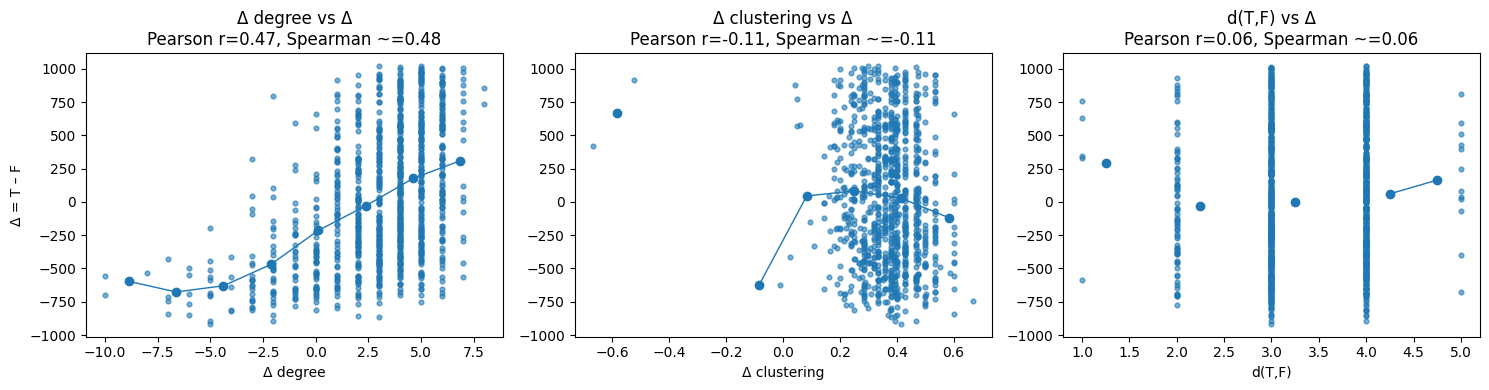

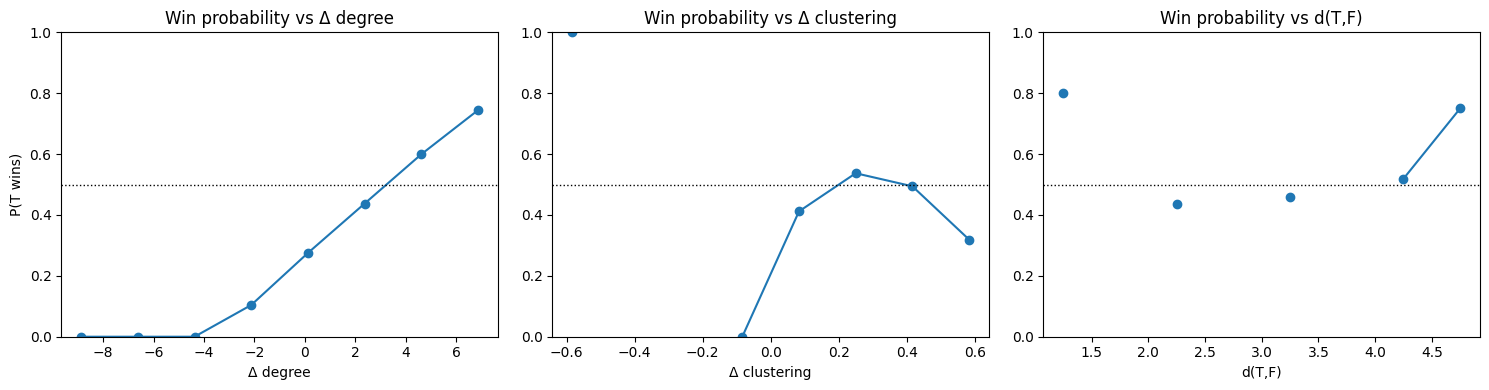

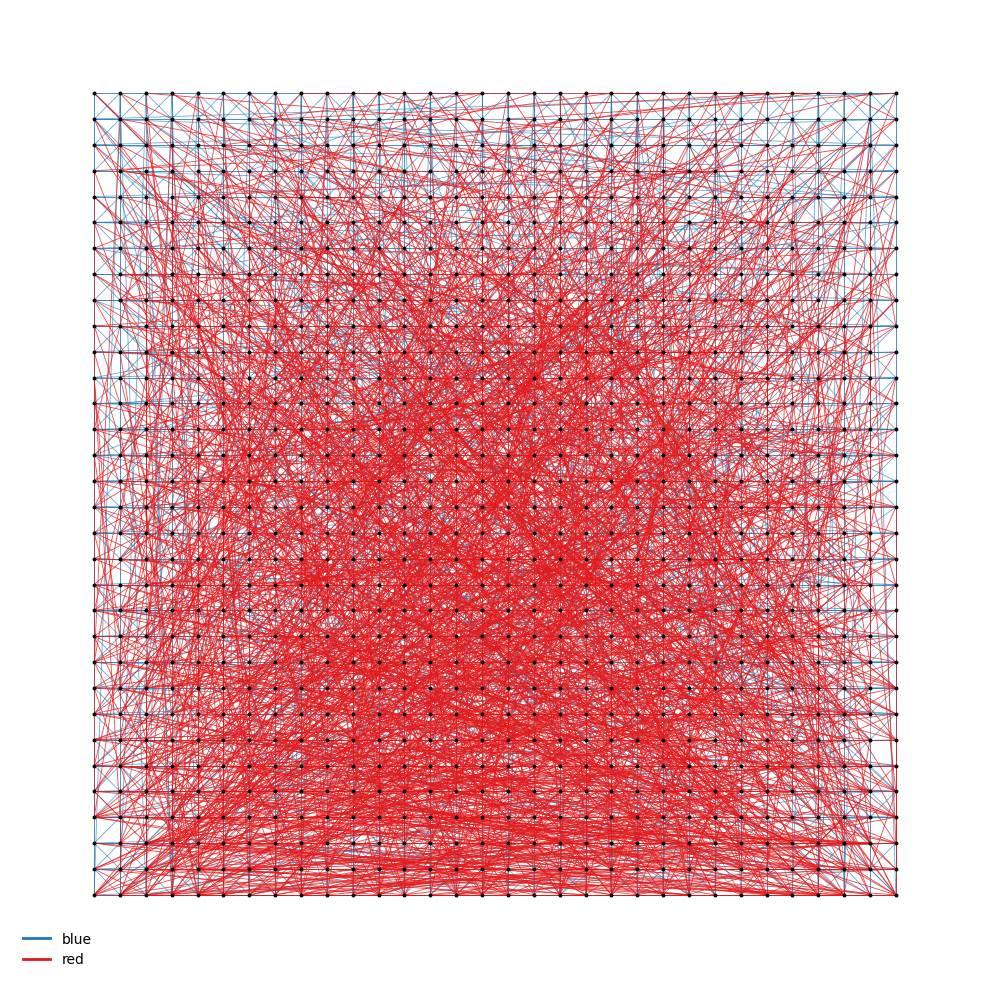

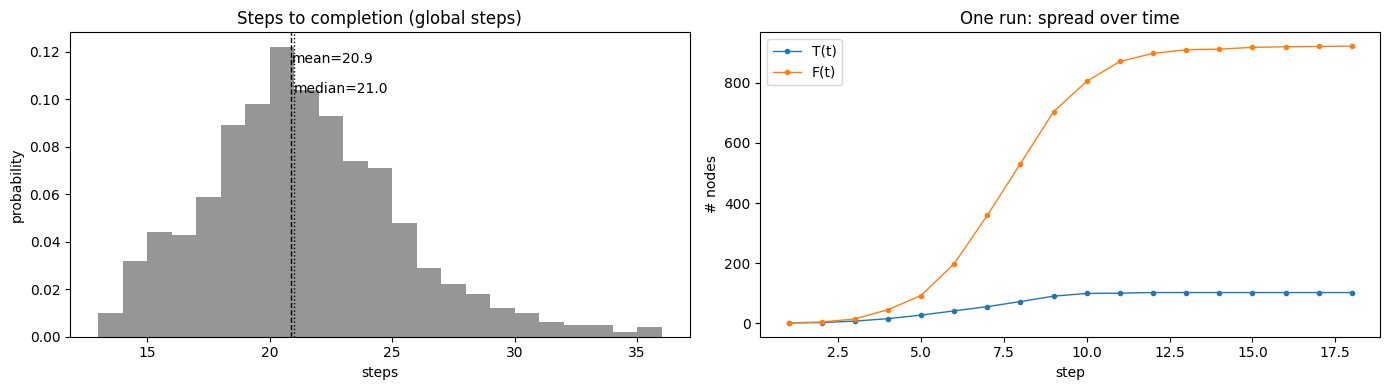

Finished – results in C:\Users\setia\Desktop\FOLDERS\CompNet project\report 6\batch_outputs
Mean leftover S: 5.172
Median leftover S: 4.0
Max leftover S: 35


In [ ]:
if __name__ == "__main__":
    
    cfg = make_cfg(
        runs=1000,
        L=32,

        blue_mode='grid_k',
        k_blue=7,          
        p_rewire=0.05,      

        m0_red=4,
        m_red=2,             # 0 disables red BA

        beta_T=0.35,
        beta_F=0.35,

        color_beta_multipliers={'blue': (1.00, 1.00),
                                'red':  (1.00, 1.00)},

        max_steps=10**100,
        seed=12345,
        outdir="batch_outputs",
        show=True,
        fixednet=True,
        print_diagnostics=True
    )
    run_batch(cfg)


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def run_batch_with_kb_scan(cfg: Config):
    outroot = pathlib.Path(cfg.outdir); outroot.mkdir(exist_ok=True)

    # Store results for each k_b
    k_b_values = np.arange(3.5, 10.5, 0.5)  # Change range to 3.5 to 10 in steps of 0.5
    results = []

    # Iterate over k_b values
    for k_b in k_b_values:
        # Set the k_b value in the config
        cfg.k_blue = k_b

        # Store outcomes for this k_b
        T_wins = 0
        F_wins = 0
        ties = 0

        # Run multiple simulations for each k_b value
        for i in range(cfg.runs):
            seed = cfg.seed + i  # Different seed for each run
            res = simulate_once(seed, cfg=cfg)

            if res['winner'] == 'T':
                T_wins += 1
            elif res['winner'] == 'F':
                F_wins += 1
            else:
                ties += 1

        # Store the result for this k_b value
        results.append({
            'k_b': k_b,
            'T_wins': T_wins,
            'F_wins': F_wins,
            'ties': ties,
            'p_T': T_wins / cfg.runs,  # Probability of T winning
            'p_F': F_wins / cfg.runs,  # Probability of F winning
        })

        # Print status update for each k_b
        print(f"Results for k_b = {k_b}:")
        print(f"  T wins: {T_wins} ({100*T_wins/cfg.runs:.2f}%)")
        print(f"  F wins: {F_wins} ({100*F_wins/cfg.runs:.2f}%)")
        print(f"  Ties: {ties} ({100*ties/cfg.runs:.2f}%)")
        print("-" * 40)

    # Extract data for plotting
    k_b_vals = [result['k_b'] for result in results]
    p_T_vals = [result['p_T'] for result in results]
    p_F_vals = [result['p_F'] for result in results]

    # Plot the results: winner fractions vs k_b
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(k_b_vals, p_T_vals, label="P(T wins)", marker='o', color='#2ca02c')
    ax.plot(k_b_vals, p_F_vals, label="P(F wins)", marker='o', color='#e41a1c')

    # Add labels and title
    ax.set_xlabel('k_b (Mean Degree of Blue Nodes)', fontsize=12)
    ax.set_ylabel('Win Probability', fontsize=12)
    ax.set_title('Winner Probability vs. k_b', fontsize=14)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

    # Output the results as well
    return results


Results for k_b = 3.5:
  T wins: 2 (0.20%)
  F wins: 998 (99.80%)
  Ties: 0 (0.00%)
----------------------------------------
Results for k_b = 4.0:
  T wins: 6 (0.60%)
  F wins: 994 (99.40%)
  Ties: 0 (0.00%)
----------------------------------------
Results for k_b = 4.5:
  T wins: 25 (2.50%)
  F wins: 974 (97.40%)
  Ties: 1 (0.10%)
----------------------------------------
Results for k_b = 5.0:
  T wins: 80 (8.00%)
  F wins: 920 (92.00%)
  Ties: 0 (0.00%)
----------------------------------------
Results for k_b = 5.5:
  T wins: 134 (13.40%)
  F wins: 865 (86.50%)
  Ties: 1 (0.10%)
----------------------------------------
Results for k_b = 6.0:
  T wins: 254 (25.40%)
  F wins: 745 (74.50%)
  Ties: 1 (0.10%)
----------------------------------------
Results for k_b = 6.5:
  T wins: 340 (34.00%)
  F wins: 660 (66.00%)
  Ties: 0 (0.00%)
----------------------------------------
Results for k_b = 7.0:
  T wins: 497 (49.70%)
  F wins: 501 (50.10%)
  Ties: 2 (0.20%)
---------------------------

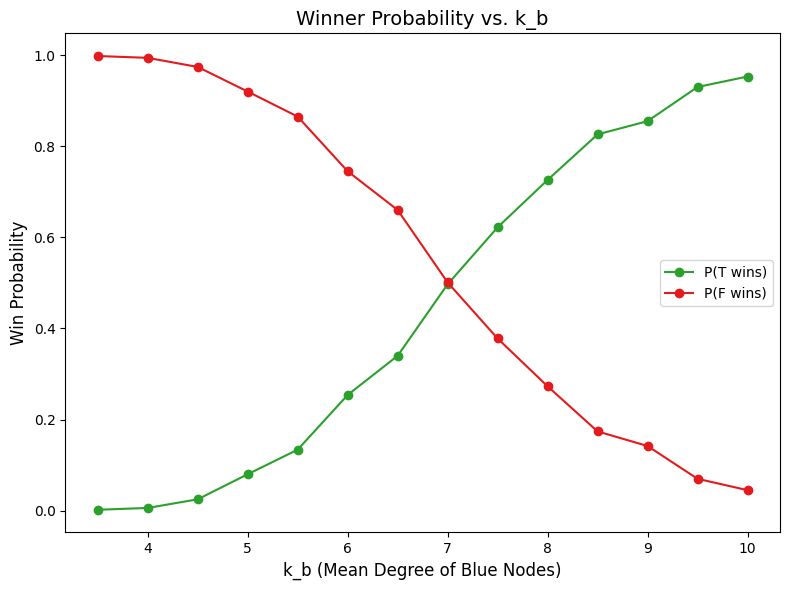

In [12]:
if __name__ == "__main__":
    # Define the configuration for running the batch
    cfg = make_cfg(
        runs=1000,
        L=32,
        blue_mode='grid_k',
        k_blue=5,          # Initial k_blue value (will be scanned)
        p_rewire=0.05,     
        m0_red=4,
        m_red=2,           # 0 disables red BA
        beta_T=0.35,
        beta_F=0.35,
        max_steps=10**100,
        seed=12345,
        outdir="batch_outputs",
        show=True,
        fixednet=True,
        print_diagnostics=True
    )
    
    # Call the new batch function that scans k_b values
    run_batch_with_kb_scan(cfg)
